# fashionMNIST-20180228

code comes from:  
https://github.com/juliensimon/dlnotebooks/blob/master/mxnet/05-Fashion%20MNIST.ipynb

# Train MXNet model on Fashion MNIST dataset

In [1]:
import mxnet as mx
from mxnet import gluon, autograd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

/Users/jeanne/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/jeanne/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
def transform(data, label):
    return mx.nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)

train_data = gluon.data.DataLoader(
    gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size=128, shuffle=True)

validation_data = gluon.data.DataLoader(
    gluon.data.vision.FashionMNIST(train=False, transform=transform), batch_size=128, shuffle=False)

/Users/jeanne/anaconda3/lib/python3.6/site-packages/mxnet/gluon/data/vision.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/Users/jeanne/anaconda3/lib/python3.6/site-packages/mxnet/gluon/data/vision.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


In [3]:
def buildCNN(cnnlayers, fclayers=([256,''],[64,'']), outputs=10, activation='relu', alpha=0.01):
    net = gluon.nn.Sequential()
    with net.name_scope():
        for l in cnnlayers:                
            if (l[0]<1.0):
                net.add(gluon.nn.Dropout(l[0]))
            else:
                net.add(gluon.nn.Conv2D(channels=l[0], kernel_size=l[1], padding=l[2], activation=None))
                if (l[5]=='BN'):
                    net.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                if (activation=='leakyrelu'):
                    net.add(gluon.nn.LeakyReLU(alpha=alpha))
                else:
                    net.add(gluon.nn.Activation(activation=activation))
                net.add(gluon.nn.MaxPool2D(pool_size=l[4], strides=l[4]))
                
        net.add(gluon.nn.Flatten())
        
        for l in fclayers:
            if (l[0]<1.0):
                net.add(gluon.nn.Dropout(l[0]))
            else:
                net.add(gluon.nn.Dense(l[0], activation=None))
                if (l[1]=='BN'):
                    net.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                if (activation=='leakyrelu'):        
                    net.add(gluon.nn.LeakyReLU(alpha=alpha))
                else:
                    net.add(gluon.nn.Activation(activation=activation))
            
        net.add(gluon.nn.Dense(outputs))
    return net

In [4]:
def init(net, optimizer='sgd', learning_rate=0.1, weight_decay=1e-6):
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24))
    trainer = gluon.Trainer(net.collect_params(), 
                            optimizer, 
                            {'learning_rate': learning_rate, 'wd': weight_decay})
    return trainer

In [5]:
def accuracy(data_iterator, net,ctx=mx.cpu()):
    acc = mx.metric.Accuracy()
    for (data, label) in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [6]:
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
    training_accuracies = []
    validation_accuracies = []
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    for e in range(epochs):
        tic = time.time()
        for (data, label) in train_data:
            data  = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
                loss.backward()
            trainer.step(data.shape[0])
        toc = time.time()
        train_accuracy = accuracy(train_data, net)
        training_accuracies.append(train_accuracy)
        validation_accuracy = accuracy(validation_data, net)
        validation_accuracies.append(validation_accuracy)
        print("Epoch#%d Time=%.2f Training=%.4f Validation=%.4f Diff=%.4f" 
              % (e, toc-tic, train_accuracy, validation_accuracy, train_accuracy-validation_accuracy))
    return training_accuracies, validation_accuracies

In [7]:
epochs = 50
# 1x28x28 -CONV-> 64x28x28 -POOL-> 64x13x13 -CONV-> 64x10x10 -POOL-> 64x5x5 --> 1600 -FC-> 256 -FC-> 64 -FC-> 10
net = buildCNN(([64,3,1,2,2,''],[64,3,0,2,2,'']))
print(net)
trainer = init(net)
training_accuracies, validation_accuracies = train(net, trainer, train_data, validation_data, epochs)
plot_accuracies(training_accuracies, validation_accuracies)

Sequential(
  (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Activation(relu)
  (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (3): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1))
  (4): Activation(relu)
  (5): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (6): Flatten
  (7): Dense(None -> 256, linear)
  (8): Activation(relu)
  (9): Dense(None -> 64, linear)
  (10): Activation(relu)
  (11): Dense(None -> 10, linear)
)
Epoch#0 Time=32.13 Training=0.8027 Validation=0.8009 Diff=0.0018
Epoch#1 Time=33.36 Training=0.8520 Validation=0.8511 Diff=0.0009
Epoch#2 Time=31.75 Training=0.8632 Validation=0.8641 Diff=-0.0009
Epoch#3 Time=31.60 Training=0.8859 Validation=0.8792 Diff=0.0067
Epoch#4 Time=31.93 Training=0.8800 Validation=0.8764 Diff=0.0036
Epoch#5 Time=32.26 Training=0.8790 Validation=0.8762 Diff=0.0028
Epoch#6 Time=31.14 Training=0.9041 Validation=0.8956 Diff=0.0085
Epoch#7 Time=33.31 Trai

NameError: name 'plot_accuracies' is not defined

In [8]:
def plot_accuracies(training_accuracies, validation_accuracies):
    epochs = len(training_accuracies)
    plt.clf()
    fig, ax = plt.subplots()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    train_plot, = ax.plot(range(epochs), training_accuracies, label="Training accuracy")
    validation_plot, = ax.plot(range(epochs), validation_accuracies, label="Validation accuracy")
    plt.legend(handles=[train_plot,validation_plot])
    plt.xticks(np.arange(0, epochs, 5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
    plt.show()

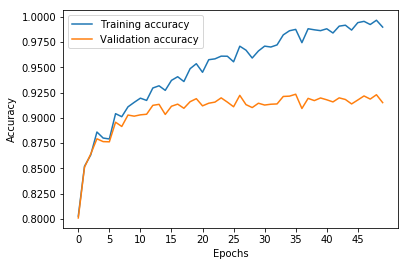

In [9]:
plot_accuracies(training_accuracies, validation_accuracies)

More things to think about from the UnofficialGoogleDataScience Blog: 

- data collection and setup
- check for vital signs and consistency between historical and present data
- measure same underlying phenomenon in different ways then check for consistency
- meausure same underlying phenomenon using different data sources 
